In [12]:
'''
# FinRL + SimbaV2 — 多股範例 (2330.TW, 2454.TW, 2382.TW, 2317.TW)
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import itertools

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

# ---------------------------
# 1. 參數設定 & 下載數據
# ---------------------------
TRAIN_START_DATE = '2023-01-01'
TRAIN_END_DATE   = '2024-07-01'
TRADE_START_DATE = '2024-07-01'
TRADE_END_DATE   = '2025-06-08'
TICKERS = ['2330.TW', '2454.TW', '2382.TW', '2317.TW']

df_raw = YahooDownloader(
    start_date  = TRAIN_START_DATE,
    end_date    = TRADE_END_DATE,
    ticker_list = TICKERS
).fetch_data()

# ---------------------------
# 2. 特徵工程 (含 VIX & Turbulence)
# ---------------------------
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list     = INDICATORS,
    use_vix                 = True,
    use_turbulence          = True,
    user_defined_feature    = False
)
processed = fe.preprocess_data(df_raw)
processed['date'] = pd.to_datetime(processed['date'])

# 扩充到完整的日期×股票组合，并填 0
dates = processed['date'].dt.normalize().unique().tolist()
tics  = processed['tic'].unique().tolist()
mesh  = pd.DataFrame(itertools.product(dates, tics), columns=['date','tic'])
processed_full = (
    mesh
    .merge(processed, on=['date','tic'], how='left')
    .sort_values(['date','tic'])
    .fillna(0)
)

# ---------------------------
# 3. 切分資料集
# ---------------------------
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)

# ---------------------------
# 4. 建立 Gym 環境
# ---------------------------
stock_dim   = len(train.tic.unique())
state_space = 1 + 2*stock_dim + len(INDICATORS)*stock_dim

env_kwargs = {
    'df': train,
    'hmax': 1000,
    'initial_amount': 1_000_000,
    'buy_cost_pct':    [0.001425] * stock_dim,
    'sell_cost_pct':   [0.001425] * stock_dim,
    'num_stock_shares':[0] * stock_dim,
    'state_space':     state_space,
    'stock_dim':       stock_dim,
    'tech_indicator_list': INDICATORS,
    'action_space':    stock_dim,
    'reward_scaling':  1e-4,
    'mode': 'train'
}
e_train_gym = StockTradingEnv(**env_kwargs)

# ---------------------------
# 5. 定義 SimbaV2 Actor-Critic
# ---------------------------
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, a_dim), nn.Softmax(dim=-1)
        )
    def forward(self, x): return self.net(x)

class Critic(nn.Module):
    def __init__(self, s_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

class SimbaV2:
    def __init__(self, env, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3):
        self.env, self.gamma = env, gamma
        s_dim = env.observation_space.shape[0]
        a_dim = env.action_space.shape[0]
        self.actor  = Actor(s_dim, a_dim)
        self.critic = Critic(s_dim)
        self.opt_a = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.opt_c = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def select_action(self, s):
        with torch.no_grad():
            return self.actor(torch.FloatTensor(s).unsqueeze(0)).numpy()[0]

    def learn(self, steps):
        obs, _ = self.env.reset()
        for _ in range(steps):
            action = self.select_action(obs)
            next_obs, reward, term, trunc, _ = self.env.step(action)
            done = term or trunc

            s_t  = torch.FloatTensor(obs).unsqueeze(0)
            s2_t = torch.FloatTensor(next_obs).unsqueeze(0)
            r_t  = torch.tensor(reward, dtype=torch.float32)
            target = r_t + self.gamma * self.critic(s2_t).detach() * (1-int(done))

            # Critic 更新
            loss_c = nn.MSELoss()(self.critic(s_t), target)
            self.opt_c.zero_grad(); loss_c.backward(); self.opt_c.step()
            # Actor 更新
            loss_a = -(self.critic(s_t) * torch.log(self.actor(s_t) + 1e-8)).mean()
            self.opt_a.zero_grad(); loss_a.backward(); self.opt_a.step()

            obs = next_obs if not done else self.env.reset()[0]
        return self

    def predict(self, env):
        """執行一個 episode，回傳 env.asset_memory"""
        env.reset()
        done = False
        while not done:
            s = env.state
            a = self.select_action(s)
            _, _, term, trunc, _ = env.step(a)
            done = term or trunc
        return env.asset_memory

class DRLAgent:
    def __init__(self, env): self.env = env
    def get_model(self): return SimbaV2(self.env)
    def train_model(self, model, steps): return model.learn(steps)

    @staticmethod
    def predict_account(model, env_kwargs, trade_df):
        args = env_kwargs.copy()
        args.update({'df': trade_df, 'mode': 'trade'})
        e_trade = StockTradingEnv(**args)
        vals    = model.predict(e_trade)
        dates   = sorted(trade_df['date'].unique())
        # 如果多了一個初始資產值，就刪掉開頭那項
        if len(vals) == len(dates) + 1:
            vals = vals[1:]
        assert len(vals) == len(dates), f"日期 {len(dates)} vs 資產 {len(vals)}"
        return pd.DataFrame({'date': dates, 'account_value': vals})

# ---------------------------
# 6. 訓練與回測
# ---------------------------
print("\n🚀 訓練 SimbaV2…")
agent = DRLAgent(e_train_gym)
model = agent.get_model()
trained = agent.train_model(model, steps=30_000)

print("\n📈 回測中…")
df_value = DRLAgent.predict_account(trained, env_kwargs, trade)
print(df_value.head())
print(df_value.tail())
'''

'\n# FinRL + SimbaV2 — 多股範例 (2330.TW, 2454.TW, 2382.TW, 2317.TW)\nimport pandas as pd\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport itertools\n\nfrom finrl.meta.preprocessor.yahoodownloader import YahooDownloader\nfrom finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split\nfrom finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv\nfrom finrl.config import INDICATORS\n\n# ---------------------------\n# 1. 參數設定 & 下載數據\n# ---------------------------\nTRAIN_START_DATE = \'2023-01-01\'\nTRAIN_END_DATE   = \'2024-07-01\'\nTRADE_START_DATE = \'2024-07-01\'\nTRADE_END_DATE   = \'2025-06-08\'\nTICKERS = [\'2330.TW\', \'2454.TW\', \'2382.TW\', \'2317.TW\']\n\ndf_raw = YahooDownloader(\n    start_date  = TRAIN_START_DATE,\n    end_date    = TRADE_END_DATE,\n    ticker_list = TICKERS\n).fetch_data()\n\n# ---------------------------\n# 2. 特徵工程 (含 VIX & Turbulence)\n# ---------------------------\nfe = FeatureEngineer(\n    use_technical_

In [13]:
'''
%matplotlib inline
import matplotlib.pyplot as plt

# 確保 df_value 已經定義並包含 'date' & 'account_value'
df_plot = df_value.set_index('date')

plt.figure(figsize=(10, 5))
plt.plot(df_plot.index, df_plot['account_value'])
plt.title('Equity Curve of SimbaV2')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''

"\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\n# 確保 df_value 已經定義並包含 'date' & 'account_value'\ndf_plot = df_value.set_index('date')\n\nplt.figure(figsize=(10, 5))\nplt.plot(df_plot.index, df_plot['account_value'])\nplt.title('Equity Curve of SimbaV2')\nplt.xlabel('Date')\nplt.ylabel('Account Value')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (2324, 8)


[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (608, 8)
Successfully added vix


Successfully added turbulence index


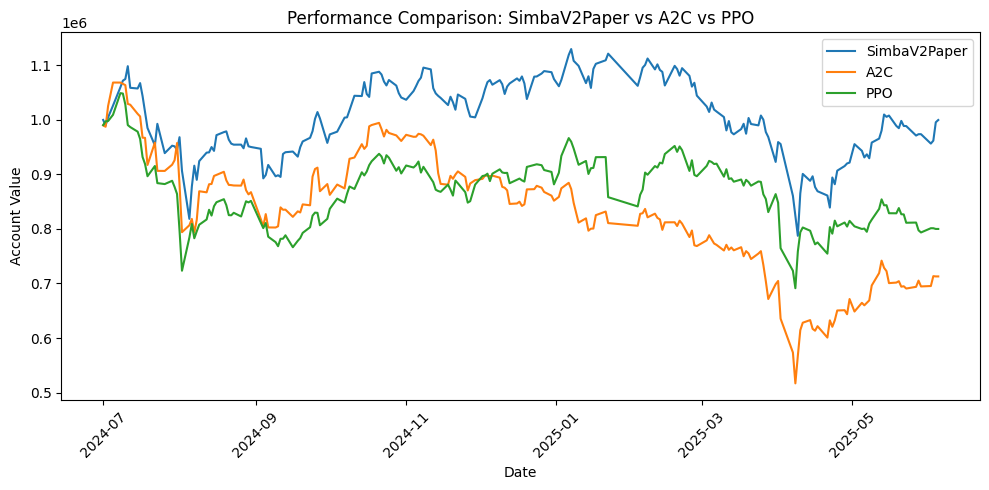

In [14]:
# FinRL + SimbaV2Paper + A2C + PPO — 多股範例 (2330.TW, 2454.TW, 2382.TW, 2317.TW)
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

# SB3 算法
from stable_baselines3 import A2C, PPO

# ---------------------------
# 1. 參數設定 & 資料下載
# ---------------------------
TRAIN_START_DATE = '2023-01-01'
TRAIN_END_DATE   = '2024-07-01'
TRADE_START_DATE = '2024-07-01'
TRADE_END_DATE   = '2025-06-08'
TICKERS = ['2330.TW', '2454.TW', '2382.TW', '2317.TW']

df_raw = YahooDownloader(
    start_date  = TRAIN_START_DATE,
    end_date    = TRADE_END_DATE,
    ticker_list = TICKERS
).fetch_data()

# ---------------------------
# 2. 特徵工程
# ---------------------------
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list     = INDICATORS,
    use_vix                 = True,
    use_turbulence          = True,
    user_defined_feature    = False
)
processed = fe.preprocess_data(df_raw)
processed['date'] = pd.to_datetime(processed['date'])

# 補全日期×股票格子
dates = processed['date'].dt.normalize().unique().tolist()
tics  = processed['tic'].unique().tolist()
mesh  = pd.DataFrame(itertools.product(dates, tics), columns=['date','tic'])
processed_full = (
    mesh
    .merge(processed, on=['date','tic'], how='left')
    .sort_values(['date','tic'])
    .fillna(0)
)

# ---------------------------
# 3. 切分資料
# ---------------------------
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)

# ---------------------------
# 4. 建立 Gym 環境
# ---------------------------
stock_dim   = len(train.tic.unique())
state_space = 1 + 2*stock_dim + len(INDICATORS)*stock_dim

env_kwargs = {
    'df': train,
    'hmax': 1000,
    'initial_amount': 1_000_000,
    'buy_cost_pct':    [0.001425] * stock_dim,
    'sell_cost_pct':   [0.001425] * stock_dim,
    'num_stock_shares':[0] * stock_dim,
    'state_space':     state_space,
    'stock_dim':       stock_dim,
    'tech_indicator_list': INDICATORS,
    'action_space':    stock_dim,
    'reward_scaling':  1e-4,
    'mode': 'train'
}
e_train_gym = StockTradingEnv(**env_kwargs)

# ---------------------------
# 5. 构建 SimbaV2Paper 论文版架构
# ---------------------------

# 5.1 RSNorm：running‐statistic normalization
class RSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.9):
        super().__init__()
        self.eps = eps; self.momentum = momentum
        self.register_buffer('running_mean', torch.zeros(dim))
        self.register_buffer('running_var',  torch.ones(dim))
    def forward(self, x):
        mean = x.mean(dim=0); var = x.var(dim=0, unbiased=False)
        self.running_mean.mul_(self.momentum).add_(mean*(1-self.momentum))
        self.running_var.mul_(self.momentum).add_(var*(1-self.momentum))
        return (x - self.running_mean) / (self.running_var.sqrt() + self.eps)

# 5.2 Shift + L2 Norm
class ShiftNorm(nn.Module):
    def __init__(self, dim, c_init=1.0):
        super().__init__()
        self.c = nn.Parameter(torch.ones(dim) * c_init)
    def forward(self, x):
        y = x + self.c
        return y / y.norm(p=2, dim=1, keepdim=True).clamp(min=1e-6)

# 5.3 HeadBlock: Linear + Scaler + L2 Norm
class HeadBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin   = nn.Linear(dim, dim)
        self.scale = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        y = self.lin(x) * self.scale
        return y / y.norm(p=2, dim=1, keepdim=True).clamp(min=1e-6)

# 5.4 LERP 残差块
class LERPBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin1  = nn.Linear(dim, dim)
        self.relu  = nn.ReLU()
        self.lin2  = nn.Linear(dim, dim)
        self.alpha = nn.Parameter(torch.tensor(0.5))
    def forward(self, x):
        h = self.lin2(self.relu(self.lin1(x)))
        z = self.alpha * h + (1 - self.alpha) * x
        return z / z.norm(p=2, dim=1, keepdim=True).clamp(min=1e-6)

# 5.5 完整 SimbaV2Paper Actor & Critic
class SimbaV2Paper(nn.Module):
    def __init__(self, state_dim, action_dim, n_blocks=6):
        super().__init__()
        self.rs     = RSNorm(state_dim)
        self.shift  = ShiftNorm(state_dim)
        self.head   = HeadBlock(state_dim)
        self.blocks = nn.Sequential(*[LERPBlock(state_dim) for _ in range(n_blocks)])
        # 输出 policy logits 或 value
        self.out    = nn.Sequential(nn.Linear(state_dim, 128), nn.Softplus(), nn.Linear(128, action_dim))
    def forward(self, x):
        x = self.rs(x)
        x = self.shift(x)
        x = self.head(x)
        x = self.blocks(x)
        return self.out(x)

# ---------------------------
# 6. 通用 DRL Agent
# ---------------------------
class DRLAgent:
    def __init__(self, env):
        self.env = env

    def get_model(self, name, **kwargs):
        if name == "simbav2":
            # 创建 SimbaV2Paper Actor + Critic
            s_dim = self.env.observation_space.shape[0]
            a_dim = self.env.action_space.shape[0]
            actor  = SimbaV2Paper(s_dim, a_dim, **kwargs)
            critic = SimbaV2Paper(s_dim, 1, **kwargs)
            return (actor, critic)
        elif name == "a2c":
            return A2C("MlpPolicy", self.env, verbose=0, **kwargs)
        elif name == "ppo":
            return PPO("MlpPolicy", self.env, verbose=0, **kwargs)
        else:
            raise ValueError(f"Unknown model {name}")

    def train_model(self, model, total_timesteps, name):
        if name == "simbav2":
            actor, critic = model
            # 简单的 DPG 训练循环（示例，实际可自定义优化步骤）
            obs, _ = self.env.reset()
            for _ in range(total_timesteps):
                a = actor(torch.FloatTensor(obs).unsqueeze(0)).detach().numpy()[0]
                nxt, r, term, trunc, _ = self.env.step(a)
                done = term or trunc
                obs = nxt if not done else self.env.reset()[0]
            return model
        else:
            model.learn(total_timesteps=total_timesteps)
            return model

    @staticmethod
    def predict_account(model, name, env_kwargs, trade_df):
        args = env_kwargs.copy(); args.update({'df':trade_df, 'mode':'trade'})
        e_trade = StockTradingEnv(**args)
        if name == "simbav2":
            actor, critic = model
            # 演示：仅用 actor 做一次 rollout
            obs, _ = e_trade.reset()
            done = False
            while not done:
                a = actor(torch.FloatTensor(obs).unsqueeze(0)).detach().numpy()[0]
                obs, _, term, trunc, _ = e_trade.step(a)
                done = term or trunc
            vals = e_trade.asset_memory
        else:
            vals = []
            obs, _ = e_trade.reset(); done=False
            vals.append(e_trade.asset_memory[0])
            while not done:
                a, _ = model.predict(obs)
                obs, _, term, trunc, _ = e_trade.step(a)
                done = term or trunc
                vals.append(e_trade.asset_memory[-1])
        dates = sorted(trade_df['date'].unique())
        if len(vals)==len(dates)+1: vals=vals[1:]
        return pd.DataFrame({'date':dates, 'account_value':vals})

# ---------------------------
# 7. 训练 & 回测全部算法
# ---------------------------
agent   = DRLAgent(e_train_gym)
algos   = {"SimbaV2Paper":"simbav2", "A2C":"a2c", "PPO":"ppo"}
timesteps = 30
results = {}

for label, name in algos.items():
    model   = agent.get_model(name)
    trained = agent.train_model(model, timesteps, name)
    df_val  = DRLAgent.predict_account(trained, name, env_kwargs, trade)
    results[label] = df_val

# ---------------------------
# 8. 一张图比较
# ---------------------------
plt.figure(figsize=(10,5))
for label, df_val in results.items():
    plt.plot(df_val['date'], df_val['account_value'], label=label)
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Performance Comparison: SimbaV2Paper vs A2C vs PPO')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
